# Summary 
Analysis of 2010 SAT scores for schools in NYC

# Disclaimer
Csv files provided by Dataquest. Part 1 was written as part of a Dataquest course. Part 2 was written as a guided project from Dataquest

# Part 1

# Read in the data

In [1]:
import numpy
import re
import pandas as pd

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for file in data_files:
    key = file.split('.')[0]
    path = 'schools/'+file
    data[key] = pd.read_csv(path)

# Read in the surveys

In [2]:
all_survey = pd.read_csv('schools/survey_all.txt', delimiter = '\t', encoding = 'windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter = '\t', encoding = 'windows-1252')

survey = pd.concat([all_survey, d75_survey], axis = 0 )

survey ['DBN'] = survey ['dbn']

survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11",
                 "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", 
                 "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

survey = survey[survey_fields]
data['survey'] = survey

# Add District Borough Number (DBN) columns

In [3]:


data['hs_directory']['DBN'] = data['hs_directory']['dbn']

#Function to pad csd codes
#Pad '0' if csd is too short
def padcsd (csd):
    csd = str(csd)
    if len(csd)<2:
        csd = '0' + csd
    return csd


data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(padcsd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

# Convert columns to numeric

In [4]:
SAT_scores = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

data['sat_results']['sat_score'] = [0] * data['sat_results']['SAT Math Avg. Score'].size

for scores in SAT_scores:
    data['sat_results'][scores] = pd.to_numeric (data['sat_results'][scores], errors = 'coerce')
    data['sat_results']['sat_score']= data['sat_results']['sat_score'] + data['sat_results'][scores] 



In [5]:
#get longitude and latitude of districts
import re

def get_lat (i):
    long_lat_str = re.findall("\(.+, .+\)", i)[0]
    lat = long_lat_str.split(',')[0]
    lat = lat.replace('(', '')
    return lat

def get_long (i):
    long_lat_str = re.findall("\(.+, .+\)", i)[0]
    long = long_lat_str.split(',')[1]
    long = long.replace(')', '')
    return long

data ['hs_directory']['lon'] = data ['hs_directory']['Location 1'].apply(get_long)
data ['hs_directory']['lat'] = data ['hs_directory']['Location 1'].apply(get_lat)

data ['hs_directory']['lon'] = pd.to_numeric(data ['hs_directory']['lon'], errors = 'coerce')
data ['hs_directory']['lat'] = pd.to_numeric(data ['hs_directory']['lat'], errors = 'coerce')

# Condense datasets

In [6]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '].isin(['09-12'])]
class_size = class_size[class_size['PROGRAM TYPE'].isin(['GEN ED'])]

class_size = class_size.groupby('DBN')
class_size = class_size.agg(numpy.mean)

class_size.reset_index(inplace = True)
data['class_size'] = class_size

demographics = data['demographics']
demographics = demographics [ demographics['schoolyear'].isin([20112012])]
data['demographics'] = demographics

graduation = data['graduation']
graduation = graduation [(graduation ['Cohort']=='2006') & (graduation['Demographic'] == 'Total Cohort')]
data['graduation'] = graduation

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors = 'coerce')

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge( right = data['ap_2010'], how = 'left', on = 'DBN')
combined = combined.merge( right = data['graduation'], how = 'left', on = 'DBN')

combined = combined.merge(right = data['class_size'], on = 'DBN', how = 'inner')
combined = combined.merge(right = data['demographics'], on = 'DBN', how = 'inner')
combined = combined.merge(right = data['survey'], on = 'DBN', how = 'inner')
combined = combined.merge(right = data['hs_directory'], on = 'DBN', how = 'inner')

means = combined.mean()
combined = combined.fillna(means)
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def ext_char (i):
    return i[0:2]

combined ['school_dist'] = combined['DBN'].apply(ext_char)

# Find correlations between SAT score and table columns

In [10]:
correlations = combined.corr()
correlations = correlations['sat_score']
sorted_correlations = correlations.sort_values(ascending = False)
print (sorted_correlations)

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                                0.339435
saf_s_11            

Initial Analysis: The correlations to the SAT columns are trivial and should be ignored. The next highest 2 correlations are racial percentages (white and asian). AP participation is the third highest correlation. Note that these correlations are preliminary and not deterministic. More data cleaning and analysis is needed for a more accurate picture.

# Part 2

# Plot Correlations to Surveys

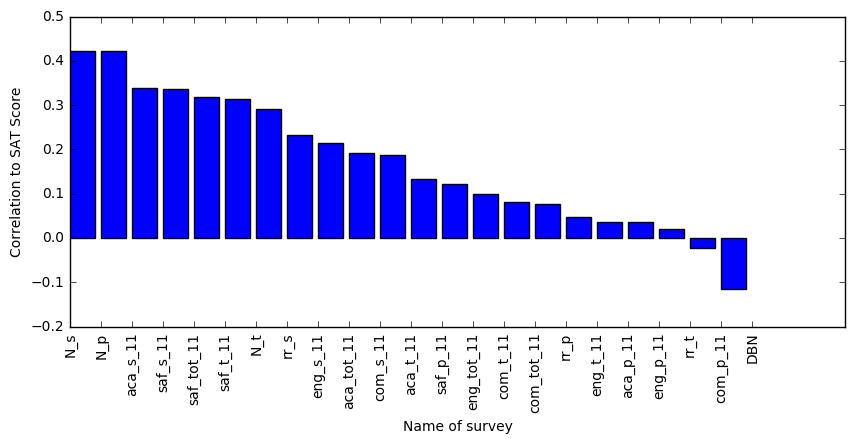

In [11]:
import matplotlib.pyplot as plt

survey_correlations = correlations[survey_fields]
survey_correlations.sort_values(inplace = True, ascending = False)

fig = plt.figure(figsize = (10,4))
sub = fig.add_subplot(111)
sub.bar(left = range(0, len(survey_fields), 1), height = survey_correlations)
sub.set_xticklabels(survey_correlations.keys(), rotation = 90)
sub.set_xticks(range(0, len(survey_fields), 1))
sub.set_ylabel('Correlation to SAT Score')
sub.set_xlabel('Name of survey')

plt.show()


Future work: Need to translate name of surveys

# Safety vs SAT score scatter plot

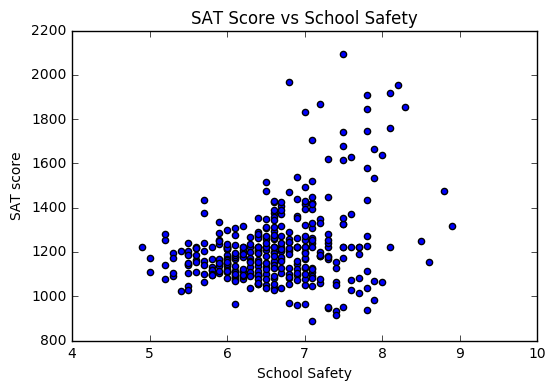

In [22]:
plt.scatter(x = combined['saf_s_11'], y = combined ['sat_score'])
plt.title('SAT Scores vs School Safety')
plt.xlabel('School Safety')
plt.ylabel('SAT score')
plt.show()

Initial analysis: We see a correlation between higher safety scores and SAT scores. 

# Map of safety scores

In [13]:
#compute average safety score by district
districts = combined.groupby('school_dist').agg(numpy.mean)
districts['safety']= combined.groupby('school_dist').agg(numpy.mean)['saf_s_11']
districts.reset_index( level = 'school_dist', inplace = True)

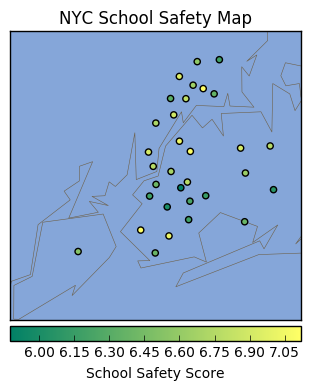

In [14]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

dist_safety = m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c = districts['safety'], cmap = 'summer')
color_bar = m.colorbar(dist_safety, location = 'bottom')
color_bar.set_label('School Safety Score')
plt.title('NYC School Safety Map')
plt.show()

Future work: Beautify graph, show district borders.

# Race and SAT scores

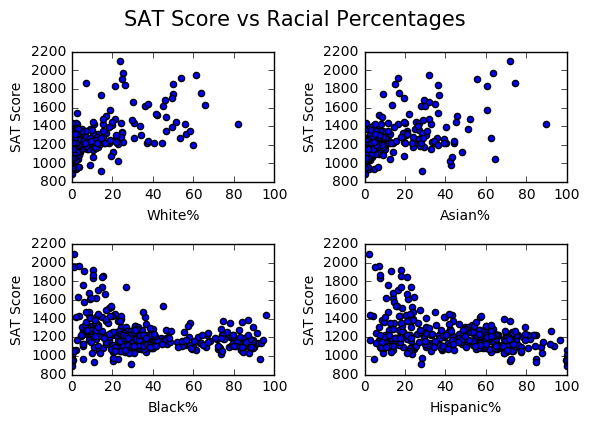

In [29]:
#scatter plots of race % vs. sat score
race_col = ['white_per', 'asian_per', 'black_per', 'hispanic_per']


#plt.scatter (x=combined['white_per'], y = combined['sat_score'])
fig = plt.figure()
fig.suptitle('SAT Scores vs Racial Percentages', fontsize = 15, y = 1.05)

i=1
for race in race_col:
    fig.add_subplot(2,2,i)
    plt.scatter (x=combined[race], y = combined['sat_score'])
    plt.ylabel('SAT Score')
    plt.xlim(0,100)
    plt.xlabel(race.split('_')[0].title() + "%")
    i+=1


plt.tight_layout()
plt.show()

Initial analysis: Positive correlation observed between SAT scores and White/Asian percentages. Negative correlation observed between SAT scores and Black/Hispanic percentages. Highest SAT score has ~75% Asian, ~25% White, ~5% Hispanic, and 0% Black. Investigate which school that is in the future.

In [16]:
#Schools with >95% hispanics

hisp_maj_schools = combined [combined['hispanic_per']>95]

print (hisp_maj_schools.head())

        DBN                                        SCHOOL NAME  \
44   02M542                      MANHATTAN BRIDGES HIGH SCHOOL   
82   06M348   WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL   
89   06M552  GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...   
125  09X365                ACADEMY FOR LANGUAGE AND TECHNOLOGY   
141  10X342              INTERNATIONAL SCHOOL FOR LIBERAL ARTS   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
44                      66                            336.0   
82                      70                            380.0   
89                      56                            339.0   
125                     54                            315.0   
141                     49                            300.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
44                 378.0                   344.0     1058.0   
82                 395.0                   399.0     1174.0   
89                 349.0           

In [17]:
#Schools with <10% hispanics and >1800 SAT scores

hisp_min_schools = combined [(combined['hispanic_per']<10)
                             &(combined['sat_score']>1800)]

print (hisp_min_schools.head())

        DBN                                        SCHOOL NAME  \
37   02M475                             STUYVESANT HIGH SCHOOL   
151  10X445                       BRONX HIGH SCHOOL OF SCIENCE   
187  13K430                     BROOKLYN TECHNICAL HIGH SCHOOL   
327  28Q687  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...   
356  31R605                STATEN ISLAND TECHNICAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
37                     832                            679.0   
151                    731                            632.0   
187                   1277                            587.0   
327                    121                            612.0   
356                    227                            635.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
37                 735.0                   682.0     2096.0   
151                688.0                   649.0     1969.0   
187                659.0           

# SAT Scores vs Gender Ratio

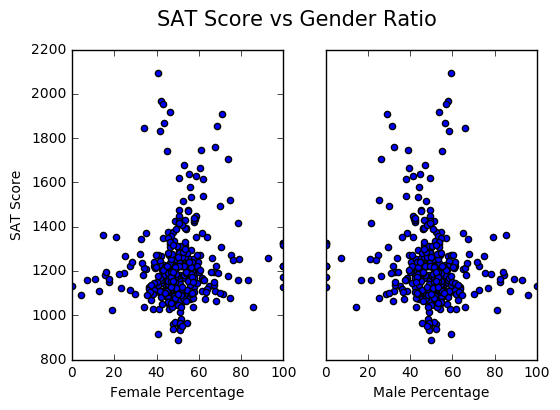

In [31]:
#scatter plots of gender % vs. sat score

fig = plt.figure()
fig.suptitle('SAT Scores vs Gender Ratio', fontsize = 15, y = 1.)

sub1 = fig.add_subplot(1,2,1)
sub1.scatter (x=combined['female_per'], y = combined['sat_score'])
sub1.set_xlabel('Female Percentage')
sub1.set_ylabel('SAT Score')
sub1.set_xlim(0,100)

sub2 = fig.add_subplot(1,2,2)
sub2.scatter (x=combined['male_per'], y = combined['sat_score'])
sub2.set_xlabel('Male Percentage')
sub2.yaxis.set_visible(False)
sub2.set_xlim(0,100)
   
plt.show()

Initial Analysis: Higher SAT scores are observed around the 50% Female/Male percentage. The highest scoring schools should be analyzed in the future in case they are outliers. All girl schools have SAT scores limited to ~1300 and all boy schools have SAT scores limited to ~1100.

In [19]:
#Schools with >60% females and >1700 SAT scores

female_schools = combined [(combined['female_per']>60)
                             &(combined['sat_score']>1700)]

print (female_schools.head())

        DBN                                        SCHOOL NAME  \
5    01M696                     BARD HIGH SCHOOL EARLY COLLEGE   
26   02M416                      ELEANOR ROOSEVELT HIGH SCHOOL   
60   03M479                                 BEACON HIGH SCHOOL   
61   03M485  FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...   
302  25Q525                        TOWNSEND HARRIS HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
5                      130                            624.0   
26                     127                            572.0   
60                     261                            577.0   
61                     531                            566.0   
302                    278                            621.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
5                  604.0                   628.0     1856.0   
26                 594.0                   592.0     1758.0   
60                 575.0           

# SAT Scores vs AP Scores

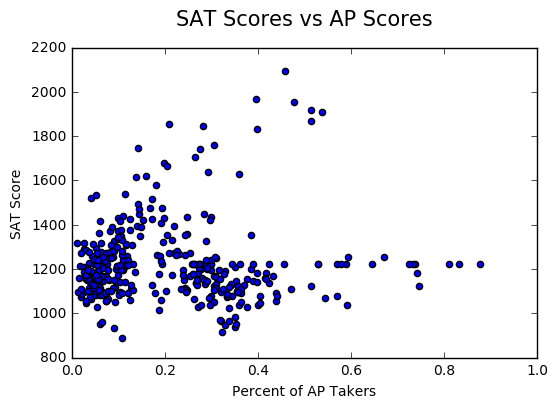

In [34]:
#Create column for % AP takers in each school
combined ['ap_per'] = combined['AP Test Takers ']/ combined['total_enrollment']
plt.title('SAT Scores vs AP Scores', fontsize = 15, y = 1.05)
plt.scatter( x = combined['ap_per'], y = combined['sat_score'])
plt.xlabel('Percent of AP Takers')
plt.ylabel('SAT Score')
plt.xlim(0,1)
plt.show()

Initial Analysis: We see two trends: 1) SAT score rising with up to ~55% AP takers 2) SAT score staying flat around 1200 for up to ~90% AP takeres. Hypothesis: Excessive focus on AP (55-90% takers) hurts SAT scores. A balanced focus on AP (~55% takers) allows students to achieve high SAT scores.

In [21]:
#!!!!!!!!future project: Read excel file of dictionary
#https://www.sitepoint.com/using-python-parse-spreadsheet-data/
import xlrd
